In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

In [2]:
import sys

sys.path.insert(0, "/home1/smaruj/akita_utils/")

from akita_utils import *

2022-06-27 12:29:11.660274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-06-27 12:29:11.660356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pysam
import h5py

In [4]:
genome_open = pysam.Fastafile("/project/fudenber_735/genomes/mm10/mm10.fa")

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Tensorflow: ", tf.__version__)

from basenji import dataset, seqnn, dna_io, stream

Tensorflow:  2.9.1


In [6]:
# NOTE
# head_i = 0 #human
# head_i = 1 #mouse
#

head_i = 1 #mouse
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models/"
model_dir = base_dir + "/f" + str(model_num) + "c0/train/"
model_file  = model_dir + "/model" + str(head_i) + "_best.h5"


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir + "/params.json"
# params_file -> json (dict) with model's parameters
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params["model"]
    params_train = params["train"]
seq_length = params_model["seq_length"]
params_model["verbose"] = False

seqnn_model = seqnn.SeqNN(params_model)
print("built")

seqnn_model.restore(model_file, head_i=head_i)    # model with the mouse head
print("restored")


2022-06-27 12:33:27.347946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-06-27 12:33:27.347991: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 12:33:27.348029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d11-05.hpc.usc.edu): /pro

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1310720, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1310720, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1310720, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [7]:
hic_diags = params_model["diagonal_offset"]
try:
    target_crop = params_model["trunk"][-2]["cropping"]
except:
    target_crop = params_model["target_crop"]

print("hic_diags: ", hic_diags) 
print("target_crop: ", target_crop)
print("seq_length: ", seq_length)

target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags) * ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size, 2)    # Return the indices for the upper-triangle of an (n, m) array, here k=2 (diagonal offset)
# target_map_size, target_length_cropped, triu_tup[0].shape

print("target_length_cropped: ", target_length_cropped)
print("target_map_size: ", target_map_size)
print("shape of triu_tup[0]: ", triu_tup[0].shape)

hic_diags:  2
target_crop:  64
seq_length:  1310720
target_length_cropped:  130305
target_map_size:  512
shape of triu_tup[0]:  (130305,)


In [8]:
background_file = base_dir + "../analysis/background_seqs.fa"
background_seqs = []
with open(background_file, "r") as f:
  for line in f.readlines():
    if ">" in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 


In [ ]:
# header example: >seq0_score5112_pixelwise28

In [9]:
background_seqs # 10 ohe background sequences

[array([[ True, False, False, False],
        [False,  True, False, False],
        [False, False, False,  True],
        ...,
        [False, False,  True, False],
        [False, False, False,  True],
        [False, False, False,  True]]),
 array([[ True, False, False, False],
        [ True, False, False, False],
        [False, False,  True, False],
        ...,
        [ True, False, False, False],
        [False, False, False,  True],
        [ True, False, False, False]]),
 array([[ True, False, False, False],
        [ True, False, False, False],
        [False, False,  True, False],
        ...,
        [False, False,  True, False],
        [False, False, False,  True],
        [False, False,  True, False]]),
 array([[ True, False, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False,  True, False]]),
 array([[False, False,  True

In [10]:
seq_coords_df = prepare_insertion_tsv(
    h5_dirs = "/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5",
    score_key = "SCD",
    pad_flank = 60, #how much flanking sequence around the sites to include
    weak_thresh_pct = 1, # don't use sites weaker than this, might be artifacts
    weak_num = 10 ,   #numer of weak examples
    strong_thresh_pct = 99, # don't use sites weaker than this, might be artifacts
    strong_num = 10 ,      # number of strong examples
    save_tsv=None, # optional filename to save a tsv
)


29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model7/scd.h5
29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model1/scd.h5
annotating each site with boundary-wide scores
filtering sites by overlap with rmsk
df prepared


In [11]:
seq_coords_df

,index,chrom,start,end,strand,genomic_SCD
0,0,chr12,35192299,35192438,-,53.656250
1,1,chr8,102781052,102781191,-,53.500000
2,2,chr5,49961931,49962070,-,53.312500
3,3,chr9,26776296,26776435,-,53.125000
4,4,chr9,51152529,51152668,-,53.062500
5,5,chr8,58566204,58566343,+,52.875000
6,6,chr12,40837671,40837810,+,52.843750
7,7,chr8,36523056,36523195,-,52.500000
8,8,chr6,101261661,101261800,-,52.500000
9,9,chr11,57467894,57468033,-,52.375000


In [12]:
s = seq_coords_df.iloc[0]
seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
print(s, seq_1hot_motif)

# s is the first motif in the seq_coords_df
# seq_1hot_motif -> core + flanks corresponing to these coordinates

insert_length = len(seq_1hot_motif)
print("Length of one CTCF-unit: ", insert_length)  # 139 = 19 (core) + 2 * 60 (flank)

index                 0
chrom             chr12
start          35192299
end            35192438
strand                -
genomic_SCD    53.65625
Name: 0, dtype: object [[ True False False False]
 [False False  True False]
 [ True False False False]
 [False False False  True]
 [False False  True False]
 [False False False  True]
 [False  True False False]
 [ True False False False]
 [False False  True False]
 [False False False  True]
 [False False False  True]
 [False False  True False]
 [False False  True False]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [False  True False False]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [False  True False False]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [ True False False False]
 [False False False  True]
 [False False  True False]
 [False False  True False]
 [False False False  True]
 [False False False  Tr

In [15]:
spacer_bp = 0
num_inserts = 6    # number of CTCF-unis that will be joined together (max)
multi_insert_length = num_inserts * (insert_length + spacer_bp)
print("Length of one multi-insert: ", multi_insert_length)
print("seq_length//2: ", seq_length//2)

offsets = []    # offsets is a list of coordinates where CTCF units will be inserted (start of the insertion to be precise)
for i in range(num_inserts):
    offsets.append( seq_length//2 - multi_insert_length//2 + i * (insert_length + spacer_bp))
    print(i, seq_length//2 - multi_insert_length//2 + i * (insert_length + spacer_bp))
# offsets

Length of one multi-insert:  834
seq_length//2:  655360
0 654943
1 655082
2 655221
3 655360
4 655499
5 655638


In [14]:
background_seqs[0:1]    # first background sequence

[array([[ True, False, False, False],
        [False,  True, False, False],
        [False, False, False,  True],
        ...,
        [False, False,  True, False],
        [False, False, False,  True],
        [False, False, False,  True]])]

In [17]:
all_inserts = []
for s in seq_coords_df.itertuples():    # iterate through rows of pandas df   -> 20 different motifs (first 10 are strong, next 10 are waek)
  for background_seq in background_seqs[0:1]:        # but everything is done for one background sequence
    seq_1hot = background_seq.copy()       # multu-CTCF-inserts are inserted into background sequences
    seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
    if s.strand == "-": seq_1hot_motif = dna_io.hot1_rc(seq_1hot_motif)    #reverse complement
    insert_length = len(seq_1hot_motif) # here, only one CTCF-unit is inserted
    for offset in offsets:
       seq_1hot[offset:offset+insert_length] = seq_1hot_motif   # insertion of motifs (precisely -> replacement), starting coordinates given by offsets list
                                                                # 6 CTCF-units are inserted 
    all_inserts.append(seq_1hot)  # overwriting
all_inserts = np.array( all_inserts)

In [20]:
all_inserts.shape

# 20 motifs
# each inserted (6 copies / CTCF-units) in the first background sequence

(20, 1310720, 4)

In [21]:
## predict for each insertion
pred = seqnn_model.predict(all_inserts, batch_size=10)   # so 20/10 = 2 batches

2/2 [==============================] - 24s 11s/step


In [22]:
pred.shape

(20, 130305, 6)

In [23]:
len(pred[0, :, 0])

130305

0 [31.83 45.25 45.25 45.25 45.25 32.  ]
1 [23.53 32.   32.   32.   32.   32.  ]
2 [24.23 32.34 45.25 45.25 32.   32.  ]
3 [27.38 32.84 45.25 43.4  32.   32.  ]
4 [23.84 32.   35.44 32.7  32.   32.  ]
5 [22.62 32.   32.   32.   32.   25.27]
6 [25.64 33.53 45.25 45.25 32.53 32.  ]
7 [23.19 32.   33.38 32.1  32.   32.  ]
8 [26.38 32.38 45.25 40.66 32.   32.  ]
9 [32.   40.88 45.25 45.25 39.25 32.  ]
10 [8.01  8.055 8.    8.    8.    5.74 ]
11 [8.    8.    8.    8.    8.    5.656]
12 [8.    8.    8.    8.    8.    5.656]
13 [8.    8.    8.    8.    8.    5.656]
14 [8.    8.    8.    8.    8.    5.656]
15 [8.    8.    8.    8.    8.    5.656]
16 [8.    8.    8.    8.    8.    5.656]
17 [8.    8.    8.    8.    8.    5.656]
18 [8.   8.01 8.   8.   8.   5.67]
19 [8.    8.    8.    8.    8.    5.656]


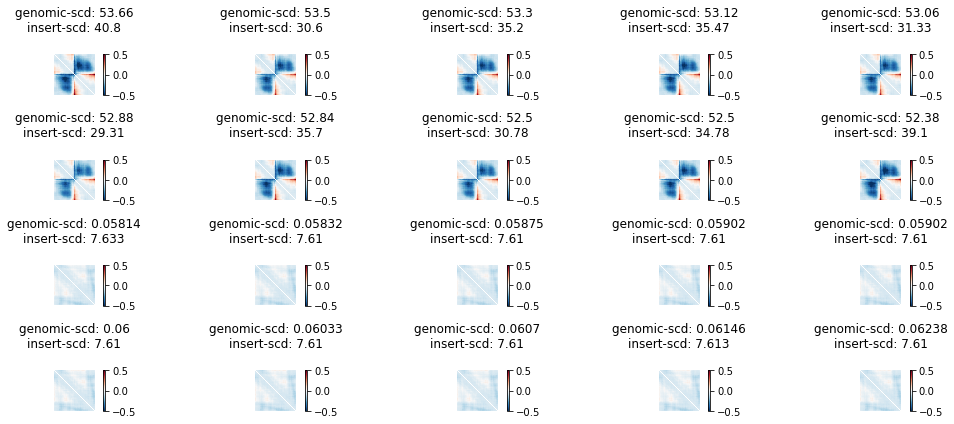

In [27]:
plt.figure(figsize=(5*3,2*3))

target_ind = 0   # first target is mESC
vlim = .5
bin_mid = target_map_size//2
window = 50
for i in range(len(seq_coords_df)):
    insert_pred = pred[i]
    print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

    plt.subplot(4, 5, i+1)
    plt.axis("off")
    im = plt.matshow(
            from_upper_triu(  
            insert_pred[:,target_ind], target_map_size, hic_diags),
            vmin=-1*vlim, vmax=vlim, fignum=False, cmap="RdBu_r")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("genomic-scd: " + str(seq_coords_df["genomic_SCD"].values[i]) + "\n" +
              "insert-scd: " + str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
              ) 
    #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
plt.tight_layout()
plt.show()